In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as plticker
import seaborn as sns
import geopandas as gpd
import matplotlib


# Retrieve and Clean data 

In [2]:
print('matplotlib: {}'. format(matplotlib. __version__))

matplotlib: 3.4.2


In [3]:
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt" 
    dfs = []
    for week_num in week_nums: 
        file_url = url.format(week_num) 
        dfs.append(pd.read_csv(file_url)) 
    return pd.concat(dfs) 

In [4]:
#COVID data set 
covid_week_nums = [200404, 200411, 200418, 200425, 200502, 200509, 200516, 200523, 200530] #Weeks of april and may 2020
peak_df1 = get_data(covid_week_nums)

In [5]:
#PRE COVID data set 
pre_covid_week_nums = [190406, 190413, 190420, 190427, 190504, 190511, 190518, 190525, 190601] # weeks of april and may 2019
pre_df1=get_data(pre_covid_week_nums)

In [6]:
#LATE COVID data set 
late_covid_week_nums = [210327, 210403, 210410, 210417, 210424, 210501, 210508, 210515, 210522] # weeks of april and may 2021
late_df1=get_data(late_covid_week_nums)

In [7]:
#clean PRE covid data 

pre_df1.columns=[x.strip() for x in pre_df1.columns]
pre_df1['snapshot_time']=pd.to_datetime(pre_df1.DATE + " " + pre_df1.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")
pre_df=(pre_df1.groupby(['C/A','UNIT','SCP','STATION','DATE','TIME'],as_index=False)[['ENTRIES','EXITS','DESC','snapshot_time']].first())

pre_df['exit_flow']= (pre_df['EXITS'].diff(-1))*-1
pre_df['entry_flow']= (pre_df['ENTRIES'].diff(-1))*-1
pre_df['net_flow']= (pre_df['entry_flow']-pre_df['exit_flow'])
pre_df['timeframe']=1
pre_df['total_flow']= (pre_df['entry_flow']+pre_df['exit_flow'])
pre_df['day_of_week']=pre_df.snapshot_time.dt.weekday
mask1 = (pre_df['entry_flow']<7200)&(pre_df['exit_flow']<7200)&(pre_df['entry_flow']>=0)&(pre_df['exit_flow']>=0)&(pre_df['DESC']=='REGULAR')&(pre_df['day_of_week']!= 5) & (pre_df['day_of_week']!= 6)
pre_df_clean = pre_df[mask1]

#groupby unique turnstile & flatten before doing flow calculations 
#my mask is a cap of entries and exits that make sense... 1 person every 2 seconds = 7200 per 4 hours block as an upper bound 
#also my mask drops non regular audits and weekends
#exit flow, entry flow refer to the NEXT 4 hours after timestamp (4am is 4am-8am) net_flow is entry-exit, positive is net entries 

In [8]:
#clean PEAK covid data 

peak_df1.columns=[x.strip() for x in peak_df1.columns]
peak_df1['snapshot_time']=pd.to_datetime(peak_df1.DATE + " " + peak_df1.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")
peak_df=(peak_df1.groupby(['C/A','UNIT','SCP','STATION','DATE','TIME'],as_index=False)[['ENTRIES','EXITS','DESC','snapshot_time']].first())

peak_df['exit_flow']= (peak_df['EXITS'].diff(-1))*-1
peak_df['entry_flow']= (peak_df['ENTRIES'].diff(-1))*-1
peak_df['net_flow']= (peak_df['entry_flow']-peak_df['exit_flow'])
peak_df['timeframe']=2
peak_df['total_flow']= (peak_df['entry_flow']+peak_df['exit_flow'])
peak_df['day_of_week']=peak_df.snapshot_time.dt.weekday
mask1 = (peak_df['entry_flow']<7200)&(peak_df['exit_flow']<7200)&(peak_df['entry_flow']>=0)&(peak_df['exit_flow']>=0)&(peak_df['DESC']=='REGULAR')&(peak_df['day_of_week']!= 5) & (peak_df['day_of_week']!= 6)
peak_df_clean = peak_df[mask1]

#groupby unique turnstile & flatten before doing flow calculations 
#my mask is a cap of entries and exits that make sense... 1 person every 2 seconds = 7200 per 4 hours block as an upper bound 
#also my mask drops non regular audits and weekends
#exit flow, entry flow refer to the NEXT 4 hours after timestamp (4am is 4am-8am) net_flow is entry-exit, positive is net entries 

In [9]:
#clean LATE covid data 

late_df1.columns=[x.strip() for x in late_df1.columns]
late_df1['snapshot_time']=pd.to_datetime(late_df1.DATE + " " + late_df1.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")
late_df=(late_df1.groupby(['C/A','UNIT','SCP','STATION','DATE','TIME'],as_index=False)[['ENTRIES','EXITS','DESC','snapshot_time']].first())

late_df['exit_flow']= (late_df['EXITS'].diff(-1))*-1
late_df['entry_flow']= (late_df['ENTRIES'].diff(-1))*-1
late_df['net_flow']= (late_df['entry_flow']-late_df['exit_flow'])
late_df['timeframe']=3
late_df['total_flow']= (late_df['entry_flow']+late_df['exit_flow'])
late_df['day_of_week']=late_df.snapshot_time.dt.weekday
mask1 = (late_df['entry_flow']<7200)&(late_df['exit_flow']<7200)&(late_df['entry_flow']>=0)&(late_df['exit_flow']>=0)&(late_df['DESC']=='REGULAR')&(late_df['day_of_week']!= 5) & (late_df['day_of_week']!= 6)
late_df_clean = late_df[mask1]

#groupby unique turnstile & flatten before doing flow calculations 
#my mask is a cap of entries and exits that make sense... 1 person every 2 seconds = 7200 per 4 hours block as an upper bound 
#also my mask drops non regular audits and weekends
#exit flow, entry flow refer to the NEXT 4 hours after timestamp (4am is 4am-8am) net_flow is entry-exit, positive is net entries 

In [ ]:
late_df_clean.groupby(['DATE']).entry_flow.sum() #sanity check of daily flow through the mta

# Define a set of "Commute Zone" stations

In [11]:
#commute zone station list: merge the top 50 morning commute stations (high exits 4am-10am) 
#and top 50 evening commute stations (high entries from 4pm-8pm)
#just do this for the pre-covid data set 
commute_home_df = pre_df_clean[(pre_df_clean['TIME'] == '16:00:00')]
commute_morning_df = pre_df_clean[(pre_df_clean['TIME'] == '04:00:00')|(pre_df_clean['TIME'] == '06:00:00')]

commute_home_df.groupby('STATION')[['exit_flow', 'entry_flow', 'net_flow']].mean().sort_values('net_flow', ascending=True).tail(50)
commute_morning_df.groupby('STATION')[['exit_flow', 'entry_flow', 'net_flow']].mean().sort_values('net_flow', ascending=True).head(50)

commute_home_zone_stations= list(commute_home_df.groupby('STATION')[['exit_flow', 'entry_flow', 'net_flow']].mean().sort_values('net_flow', ascending=True).tail(50).index.values)
commute_home_zone_stations.append('42 ST-PORT AUTH')
morning_commute_zone_stations= list(commute_morning_df.groupby('STATION')[['exit_flow', 'entry_flow', 'net_flow']].mean().sort_values('net_flow', ascending=True).head(50).index.values)
morning_commute_zone_stations
#list of commute stations
commute_stations= commute_home_zone_stations + list(set(morning_commute_zone_stations)-set(commute_home_zone_stations))

# Apply "Commute Zone" Dictionary to our data sets

In [12]:
#create dataframe of commute stations and assign areas
#do below to each timeframe
commute_stations_pre_df = pre_df_clean[pre_df_clean['STATION'].isin(commute_stations)].copy() #df thats just of commute stations
commute_stations_peak_df= peak_df_clean[peak_df_clean['STATION'].isin(commute_stations)].copy()
commute_stations_late_df= late_df_clean[late_df_clean['STATION'].isin(commute_stations)].copy()
#create commute area dictionary and assign rows 
area_dict={"Harlem/ Bronx": ['3 AV-149 ST', 'WOODLAWN', 
 '135 ST', 
 '190 ST', 
 '149/GRAND CONC',
 '168 ST'], "Downtown Brooklyn" :  ['CLARK ST', 'DEKALB AV',
 'GRAND ARMY PLAZ', 
 'BOROUGH HALL',
 'HOYT-SCHER',
 'JAY ST-METROTEC',
 'HOYT ST',
 '4 AV-9 ST',
 'SMITH-9 ST',
 'HIGH ST',
 'NEVINS ST'],'Central Manhattan':[ '6 AV', 
 '28 ST', 
 '18 ST',
 '23 ST',
 '3 AV',
 '1 AV',
 '14 ST'],# 'East Brooklyn' : [ 'JEFFERSON ST'],
'Financial District': [ 'EAST BROADWAY',
 'RECTOR ST',
 'CITY HALL',
 'WORLD TRADE CTR',
 'BOWLING GREEN',
 'PARK PLACE',
 'CANAL ST',
 'CHAMBERS ST',
 'BROOKLYN BRIDGE',
 'WALL ST'], 'LIC':[ '33 ST-RAWSON ST',
 'COURT SQ-23 ST',
 'QUEENSBORO PLZ',
 'COURT SQ'],'Lower Manhattan':  ['PRINCE ST',
 'BLEECKER ST', '2 AV',
 'SPRING ST',
 'BOWERY'], 'Midtown':[ '49 ST',
 '34 ST-HERALD SQ',
 'TIMES SQ-42 ST',
 '59 ST COLUMBUS',
 '42 ST-BRYANT PK',
 '47-50 STS ROCK',
 '57 ST-7 AV',
 '5 AV/53 ST','LEXINGTON AV/63', 
 'GRD CNTRL-42 ST',
 '51 ST',
 'LEXINGTON AV/53',
 '5 AVE',
 '5 AV/59 ST','34 ST-HUDSON YD', 
 '42 ST-PORT AUTH',],'Uptown':[ '96 ST',
 '72 ST'], 'Staten Island':['St.George'] }

temp = {j : i for i,k in area_dict.items() for j in k}
commute_stations_pre_df['area']=commute_stations_pre_df.STATION.map(temp)
commute_stations_peak_df['area']=commute_stations_peak_df.STATION.map(temp)
commute_stations_late_df['area']=commute_stations_late_df.STATION.map(temp)

#these 65 stations (17% of sample) account for ~40% of flow (~5.5m ridership daily total)

In [13]:
#pre data
df1=commute_stations_pre_df.groupby(['area','DATE','timeframe'])['entry_flow'].sum().reset_index() #area,date,entry flow sum (flattened)
df1.head(20)

average_daily_pre = df1.groupby(['area'])['entry_flow'].mean() #this is the average daily sum of entry traffic through our 66 commute stations

#peak data 
df2=commute_stations_peak_df.groupby(['area','DATE','timeframe'])['entry_flow'].sum().reset_index() #area,date,entry flow sum (flattened)
df2.head(20)

average_daily_peak = df2.groupby(['area'])['entry_flow'].mean() #this is the average daily sum of entry traffic through our 66 commute stations

#late data 
df3=commute_stations_late_df.groupby(['area','DATE','timeframe'])['entry_flow'].sum().reset_index() #area,date,entry flow sum (flattened)
df3.head(20)

average_daily_late = df3.groupby(['area'])['entry_flow'].mean() #this is the average daily sum of entry traffic through our 66 commute stations


# Barplot of three time periods raw

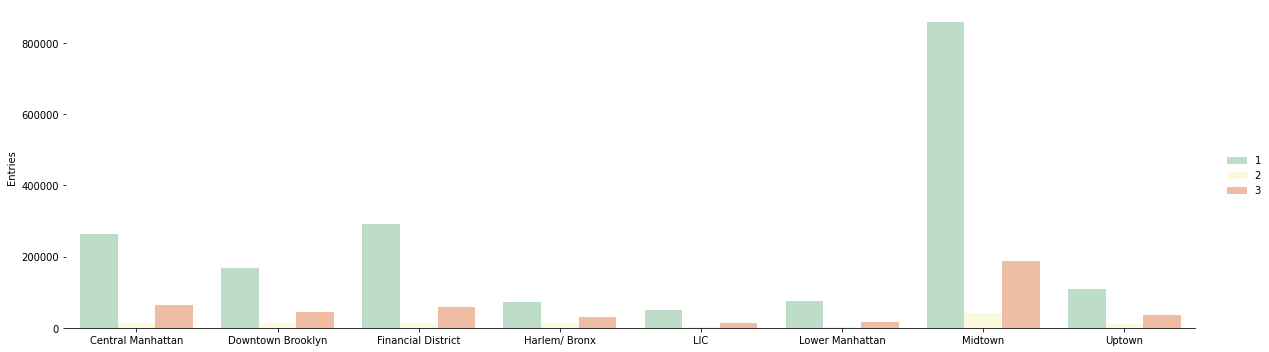

In [14]:
pre_peak_df=pd.concat([df1,df2])
pre_peak_df2=pre_peak_df.groupby(['area','timeframe']).entry_flow.mean().reset_index()
pre_peak_df3=pre_peak_df2.pivot_table(index='area', columns='timeframe').reset_index()


pre_peak_late_df=pd.concat([df1,df2,df3])
pre_peak_late_df2=pre_peak_late_df.groupby(['area','timeframe']).entry_flow.mean().reset_index()


pre_peak_df4=pre_peak_df3.set_index('area')


#barplot of the three time periods 
area_list=pre_peak_df2['area'].unique()
mylabels=["Pre-Covid", "Peak-Covid", "Late-Covid"]

    
g=sns.catplot(
    data=pre_peak_late_df2, kind="bar",
    x="area", y="entry_flow", hue="timeframe",
    ci="sd", palette="Spectral_r", alpha=.6, height=5, aspect=5/1.5
)
g.despine(left=True)
g.set_axis_labels("", "Entries")
g.legend.set_title("")


# Barplot of three time periods, in % terms (per Commute Zone)

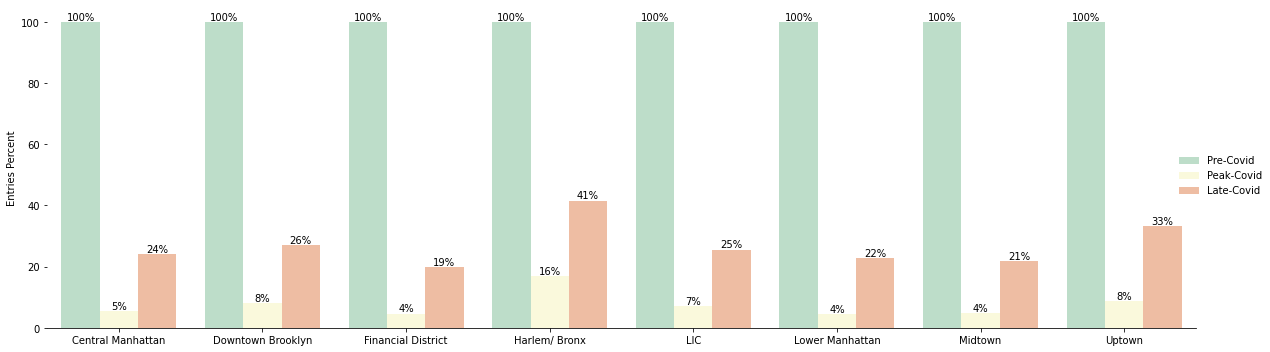

In [16]:
# pre_peak_late_df2.head(5)
#pre_peak_late_df2[['area','timeframe']].assign(change=pre_peak_late_df2.groupby('timeframe').entry_flow.pct_change().add(1)).dropna()
pre_peak_late_df2['entry_flow_shifted']=pre_peak_late_df2['entry_flow'].shift(1)
pre_peak_late_df2['pct_change']=pre_peak_late_df2['entry_flow']/pre_peak_late_df2['entry_flow_shifted']
pre_peak_late_df2['entry_flow_shifted2']=pre_peak_late_df2['entry_flow'].shift(2)
pre_peak_late_df2['pct_change2']=pre_peak_late_df2['entry_flow']/pre_peak_late_df2['entry_flow_shifted2']
pre_peak_late_df4=pre_peak_late_df2[pre_peak_late_df2['area']!='East Brooklyn']

conditions=[
    (pre_peak_late_df2['timeframe']==1), 
    (pre_peak_late_df2['timeframe']==2),
    (pre_peak_late_df2['timeframe']==3)]
values=[100, pre_peak_late_df2['pct_change']*100, pre_peak_late_df2['pct_change2']*100] 
pre_peak_late_df2['entry_flow_indexed']= np.select(conditions,values)


g3=sns.catplot(
    data=pre_peak_late_df4, kind="bar",
    x="area", y='entry_flow_indexed', hue="timeframe",
     palette="Spectral_r", alpha=.6, height=5, aspect=5/1.5,
)
mylabels=["Pre-Covid", "Peak-Covid", "Late-Covid"]


g3.despine(left=True)
g3.set_axis_labels("", "Entries Percent")
g3.legend.set_title("")

for t, l in zip(g3._legend.texts, mylabels): t.set_text(l)

    
ax2 = g3.facet_axis(0, 0)
for c in ax2.containers:
    labels = ['{:d}%'.format(int(v.get_height())) for v in c]
    #ax2.bar_label(c, labels=labels, label_type='edge')
    ax2.bar_label(c, labels=labels, label_type='edge')

# Stats to use later

In [17]:
#stats for ppt tables 
station='Harlem/ Bronx'
station_df=({'Average Daily Ridership Pre-Covid':average_daily_pre[station],'Average Daily Ridrship Peak-Covid':average_daily_peak[station],'Average Daily Ridrship Late-Covid': average_daily_late[station], 
             '% of Ridership Across MTA Pre-Covid':average_daily_pre[station]/pre_df_clean.groupby(['DATE']).entry_flow.sum().mean(),'% of Ridership Across MTA Peak-Covid':average_daily_peak[station]/peak_df_clean.groupby(['DATE']).entry_flow.sum().mean(),
            '% of Ridership Across MTA Late-Covid':average_daily_late[station]/late_df_clean.groupby(['DATE']).entry_flow.sum().mean()})

station_df
 
color_dict={'Midtown':'#FF9999', 'Harlem/ Bronx': '#CD5C5C', 'Downtown Brooklyn': '#FCA45C', 'Central Manhattan': '#FCE0C9',
            'Financial District': '#FEEBA5', 'LIC': '#FFCC66', "Lower Manhattan": '#ECF7A2', "Uptown": '#CEEACA'}


# Map Commute Zones

<AxesSubplot:>

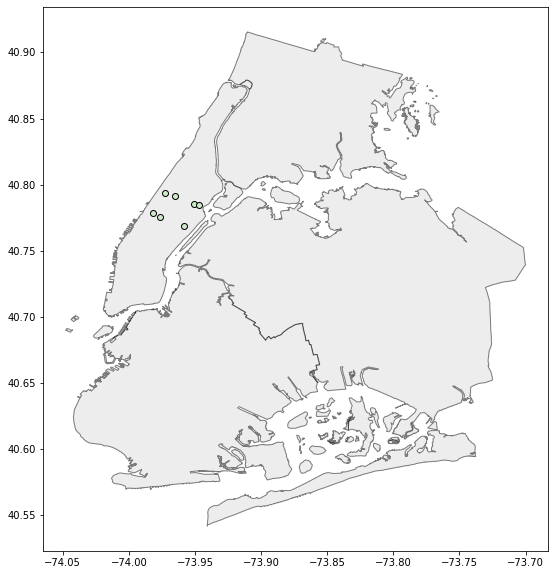

In [18]:
nyc = gpd.read_file(gpd.datasets.get_path('nybb'))
mask1=(nyc['BoroCode']== 3) |(nyc['BoroCode']== 4)|(nyc['BoroCode']== 1)|(nyc['BoroCode']== 2)
nyc2=nyc[mask1]
nyc3= nyc2.to_crs("EPSG:4258")
cmap=cm.get_cmap('Greys')
ax=nyc3.plot(figsize=(10,10), alpha=0.5, edgecolor='k', color='#DCDCDC')
#nyc2.plot(figsize=(10,10), color='#DCDCDC')
#nyc2.head(5)
#a_circle=plt.Circle((1, 220000), 500000)
#nyc2.add_artist(a_circle)
area2='Uptown'
mta_data2=pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv')
mta_data2['Stop']=mta_data2['Stop Name'].str.upper()
mta_data2['Lat']=mta_data2['GTFS Latitude']
mta_data2['Lon']=mta_data2['GTFS Longitude']
mta_data3=mta_data2[mta_data2['Stop'].isin(commute_stations)].copy()
mta_data3['area']=mta_data3.Stop.map(temp)
mta_data4=mta_data3[mta_data3['area']==area2]

gdf = gpd.GeoDataFrame(
    mta_data4, geometry=gpd.points_from_xy(mta_data4.Lon, mta_data4.Lat))
gdf.plot(ax=ax, color=color_dict[area2],edgecolor='k')
#mta_data4.head(5)

#mta data 2 is all stations
#mta data 3 is just commute stations 
#mta data 4 is per area filter 